##### 0 - Importação das Bibliotecas

In [77]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

import warnings
warnings.filterwarnings("ignore")


float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

tf.random.set_seed(123)
np.random.seed(123)

tf.get_logger().setLevel('ERROR')

fillna_const = 1.0

##### 1- Importação dos módulos de Gerenciamento de Risco e BackTest

In [78]:
from Proposta_B_risk_model import Model, pct_change, scale_0_1
from Proposta_B_bt_testcode import backtest, DynRebalance, get_name, plotAllocation, getStatistic, calc_portfolio_values
from Proposta_B_bt_testcode import plotPortfolioReturns, get_portfolio_values

##### 2 - Cálculo Estatístico do Portfólio de Ações

In [79]:
# "input alloc" - array de alocação, "stock_close" - dataframe com preços de fechamento
def calc_portfolio_values(alloc, stock_close):
    pct = np.divide(stock_close, stock_close[0])
    portfolio_values = np.sum(pct * alloc, axis=1)
    portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]
    sharpe = np.mean(portfolio_returns) / np.std(portfolio_returns)
    return np.sum(portfolio_returns ), np.std(portfolio_returns), sharpe


def print_portfolio_values(alloc, stock_close):
    pr, pstd, psharp = calc_portfolio_values(alloc, stock_close)
    print('Retorno do portfolio: R${:.4f}'.format(pr))
    print('Desvio Padrão: {:.4f}'.format(pstd))
    print('Indice Sharpe: {:.4f}'.format( psharp ))

@tf.function
def prep_scale(data):
    data = tf.cast(data, tf.float32)
    data = (data-tf.reduce_min(data, axis=0))/(tf.reduce_max(data, axis=0)-tf.reduce_min(data, axis=0) + 0.000000001)
    return data

@tf.function
def prep_cov(data):
    data = tf.cast(data, tf.float32)
    data = tfp.stats.covariance(data)
    return data

@tf.function
def prep_pct_chg(data):
    data = tf.transpose(data)
    data = tf.experimental.numpy.diff(data)/data[:,:-1]
    data = tf.transpose(data)
    data = tf.cast(data, tf.float32)
    data = tf.concat([tf.zeros([1,tf.shape(data)[1]]), data], axis=0)
    return data

@tf.function
def preprocessDataElement(x_data):
    x = np.concatenate([ scale_0_1(x_data)[1:], pct_change(x_data)[1:] ], axis=1)
    return x

@tf.function
def preprocessInputData(data, labels=None):
    pct = prep_pct_chg(data)
    data_scaled = prep_scale(data)
    return (tf.concat([data_scaled, pct],1), labels)

@tf.function
def prep_random_col(data, labels = None):
    idx = tf.random.shuffle(tf.range(tf.shape(data)[1]))
    dt = tf.gather(data, idx,axis=1)
    if labels is not None:
        lb = tf.gather(labels, idx,axis=0)
    return (dt, lb)


def getOneTrainElement(X_data, m1_train_start, m1_train_n, m2_train_n, retrain_n = 2):
    '''
    X_data - price data frame
    m1_train_start - start of trainings data
    m1_train_n - number of trainings data
    m2_train_n - number of data for y calculation 
    '''
    train_m1_x = X_data[m1_train_start:m1_train_start+m1_train_n]
    if(m2_train_n > 0):
        train_m2_x = X_data[m1_train_start+m1_train_n:m1_train_start+m1_train_n+m2_train_n]
    else:
        return train_m1_x, None, None

    _param={}
    _param ={'model_params':
        {'model_n':'LSTM',
        'epochs':1000}}
    if(retrain_n > 1):
        _y = []
        _sharp = []
        for i in range(retrain_n):
            risk_model = Model()
            _y.append( risk_model.get_allocations(train_m2_x, **_param['model_params']) )
            _p, _s, _sp = calc_portfolio_values(_y[-1],train_m2_x)
            _sharp.append(_sp)
        i = np.argmax(_sharp)
        train_m1_y = _y[i]
    else:
        risk_model = Model()
        train_m1_y = risk_model.get_allocations(train_m2_x, **_param['model_params'])
    return train_m1_x, train_m1_y, train_m2_x



def dataGenerator(X_data, m1_train_n, m2_train_n, retrain_n = 0, n = 2): 
    i = 0
    rnd_rand = X_data.shape[0] - m1_train_n - m2_train_n - 1
    if(rnd_rand < 1):
        print("ERROR: Wrong data")
        return 
    g = tf.random.Generator.from_seed(42)    
    starts = g.uniform(shape=(n,), dtype=tf.int32, minval=0, maxval=rnd_rand)
    for m1_train_start in starts:
        print(m1_train_start)
        X, y, _k = getOneTrainElement(X_data, m1_train_start, m1_train_n, m2_train_n, retrain_n)
        yield (X, y)


#### 3 - Importação e Armazenamento dos Preços do Fecamento Ajustado dos Ativos da Carteira

In [80]:
#CARTEIRA RECOMENDADA SETEMBRO 2021 - BB ASSET
# https://www.youtube.com/watch?v=869EIn4ZHxg
# Para o mês de setembro/2021 a BB asset optou por uma carteira mais defensiva, prevendo uma alta de volatilidade para o período

In [81]:
ticker = ['BPAC11.SA', 'CSMG3.SA', 'PGMN3.SA', 'ITUB4.SA', 'JBSS3.SA', 'MGLU3.SA','PETR4.SA', 'RDOR3.SA', 'VALE3.SA', 'EMBR3.SA']

history_range = {'start': datetime(2015, 1, 1), 
                 'end': datetime(2022, 8, 31)}

stock = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')
stock_close = stock.iloc[:]['Adj Close'].reset_index(drop=True).fillna(fillna_const)                

##### 3.1 - O TimeFrame utilizado é o D1

In [82]:
stock_close

Symbols,BPAC11.SA,CSMG3.SA,PGMN3.SA,ITUB4.SA,JBSS3.SA,MGLU3.SA,PETR4.SA,RDOR3.SA,VALE3.SA,EMBR3.SA
0,1.000000,5.054586,1.00,13.321705,8.347957,0.215259,4.714056,1.000000,13.442643,23.947777
1,1.000000,5.295087,1.00,13.388646,8.387520,0.219304,4.311147,1.000000,13.240497,23.417738
2,1.000000,5.333810,1.00,13.605233,8.189703,0.216414,4.170127,1.000000,13.771127,22.993717
3,1.000000,5.488711,1.00,14.097460,8.419172,0.223638,4.366548,1.000000,14.276491,22.820255
4,1.000000,5.421452,1.00,14.317972,8.490387,0.221905,4.648584,1.000000,14.428099,22.164942
...,...,...,...,...,...,...,...,...,...,...
1901,25.879999,13.250161,5.48,26.814760,30.719999,4.680000,33.279999,34.333584,69.269997,14.730000
1902,25.350000,13.022734,5.43,26.654972,29.950001,4.580000,33.639999,33.346928,68.230003,14.520000
1903,25.790001,13.329267,5.39,26.565090,30.100000,4.520000,34.480000,32.948280,66.910004,14.380000
1904,25.770000,13.210608,5.12,26.445246,29.990000,4.510000,32.430000,32.888485,64.970001,14.270000


##### 3.2 - A rede neural busca prever o preço dos ativos para os próximos 22 dias úteis, analisando os últimos 125 dias úteis anteriores 

In [83]:
ds_counter = tf.data.Dataset.from_generator(dataGenerator, args=[stock_close.values, 125, 22, 0, 1400], 
output_types=(tf.float32, tf.float32), output_shapes=((None, None), (None,)) )

In [84]:
path = "./saved_data_tmp"
dataset = ds_counter.take(1)
tf.data.experimental.save(dataset, path)

tf.Tensor(1161, shape=(), dtype=int32)
1/1 [==============================] - 1s 768ms/step


In [85]:
# Carregamento e teste
new_dataset = tf.data.experimental.load(path,element_spec=(tf.TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
 tf.TensorSpec(shape=(None,), dtype=tf.float32, name=None)))

for i, elem in enumerate(new_dataset.take(1)):
    print(elem)

(<tf.Tensor: shape=(125, 10), dtype=float32, numpy=
array([[13.9636, 17.4700, 1.0000, ..., 1.0000, 33.4833, 17.7100],
       [13.3699, 17.4126, 1.0000, ..., 1.0000, 33.1267, 17.8800],
       [13.2369, 17.4675, 1.0000, ..., 1.0000, 33.8545, 18.0500],
       ...,
       [15.8529, 15.3497, 1.0000, ..., 1.0000, 34.6320, 17.1500],
       [15.4027, 14.9980, 1.0000, ..., 1.0000, 34.6245, 16.9100],
       [15.7930, 15.6662, 1.0000, ..., 1.0000, 36.2829, 17.2400]],
      dtype=float32)>, <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
       0.0000, 0.0000], dtype=float32)>)


##### 4 - Modelagem da Rede Neural Recorrente do tipo LSTM

In [86]:
class TfModel():
    def __init__(self, input_shapes, output_shape, load_path=None, model_nr = 0):
        self.model = None
        self.history = None

        if model_nr == 1:
            self._build_model1(input_shapes, output_shape)
        elif model_nr == 2:
            self._build_model2(input_shapes, output_shape)
        else:
            self._build_model(input_shapes, output_shape)

        if load_path is not None:
            self.loadModel(load_path)

        pass

    def _build_model(self, input_shapes, output_shape):
        input_price = tf.keras.Input(shape=input_shapes['input_price'],name='input_price')
        L = layers.LSTM(128)(input_price)
        L = layers.Dense(48, activation='relu')(L)
        L =layers.Dropout(0.5)(L)
        out = layers.Dense(output_shape, activation='softmax')(L)

        self.model = tf.keras.Model(inputs=input_price, outputs=out, name="sharp_model")
        self.model.compile(optimizer='adam',
              loss='mse', 
              metrics=['accuracy'])
        pass

    def _build_model1(self, input_shapes, output_shape):
        input_price = tf.keras.Input(shape=input_shapes['input_price'],name='input_price')
        L = layers.LSTM(64)(input_price)
        L = layers.Dense(24, activation='relu')(L)
        L =layers.Dropout(0.5)(L)
        L = layers.Flatten()(L)
        out = layers.Dense(output_shape, activation='softmax')(L)

        self.model = tf.keras.Model(inputs=input_price, outputs=out, name="sharp_model")
        self.model.compile(optimizer='adam',
              loss='mse', 
              metrics=['accuracy'])
        pass

    def _build_model2(self, input_shapes, output_shape):
        input_cov = tf.keras.Input(shape=input_shapes['input_cov'],name='input_cov')
        input_price = tf.keras.Input(shape=input_shapes['input_price'],name='input_price')

        L = layers.LSTM(128, recurrent_dropout=0.3,)(input_price)
        L = layers.Dense(100, activation='relu')(L)
        L = layers.Dropout(0.3)(L)
        
        L2 = layers.LSTM(64, dropout=0.3,)(input_cov)
        L2 = layers.Dense(40, activation='relu')(L2)
        L2 = layers.Dropout(0.3)(L2)
        
        LO = tf.concat([L,L2],1)
        LO = layers.Dense(20, activation='relu')(LO)
        out = layers.Dense(output_shape, activation='softmax')(LO)

        self.model = tf.keras.Model(inputs=[input_price, input_cov], outputs=out, name="sharp_model")
        self.model.compile(optimizer='adam',
              #loss='kl_divergence', 
              loss='mse',
              metrics=['accuracy'])
        pass

    def summary(self):
        return self.model.summary()

    def trainModel(self, dataset,  n_epoch=50, batch_size=200, n_shuffle=200, n_prefetch=50, n_repeat=1, verbose = 1):
        train_ds = dataset.shuffle(n_shuffle)
        train_ds = train_ds.repeat(n_repeat)
        train_ds = train_ds.map(preprocessInputData)
        train_ds = train_ds.batch(batch_size)
        train_ds = train_ds.prefetch(n_prefetch)       
        self.history = self.model.fit(train_ds, epochs=n_epoch, verbose=verbose)
        return self.history

    def resetModel():
        pass

    def evalModel(self, dataset, batch_size=5, steps = 2):
        ds_eval = dataset.map(preprocessInputData)
        ds_eval = ds_eval.batch(batch_size)
        self.model.evaluate(ds_eval, steps=steps)
        pass
    
    def saveModel(self, path="./save_model/"):
        self.model.save(path)

    def loadModel(self, path="./save_model/"):
        self.model = tf.keras.models.load_model(path)


    def get_allocations(self, data, **param):
        m1_train_start = param['data_start_index']
        m1_train_n = param['train_period']
        m2_train_n = 0

        X, y, _k = getOneTrainElement(data, m1_train_start, m1_train_n, m2_train_n, 0)
        dataset_X = tf.data.Dataset.from_tensors(tf.cast(X,tf.float32))
        
        dataset = dataset_X.map(preprocessInputData)
        dataset = dataset.batch(1)
        alloc = self.model.predict(dataset).flatten()
        return alloc


######         Observação: Foi modelado diferentes tipos de redes neurais LSTM com configuração de camadas e neurônios distintos; "Model", "Model1" e "Model2"
###### Ao se escolher os ativos é possível encontrar variações dessas configurações no intuito de buscar melhores resultados sem o overfitting

##### 5 - Treinamento da rede LSTM

In [87]:
path = "./saved_data"
new_dataset = tf.data.experimental.load(path,element_spec=(tf.TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
 tf.TensorSpec(shape=(None,), dtype=tf.float32, name=None)))

In [88]:
tf.data.experimental.cardinality(new_dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=1000>

In [89]:
input_shapes = {}
input_shapes['input_price'] = (125,20)
input_shapes['input_cov'] = (10,10)
model = TfModel(input_shapes,10,)



In [90]:
_param={}
_param ={'model_params':
    {'data_start_index':0,
     'train_period':125,
     'predict_period':22}}
model.get_allocations(stock_close.values, **_param['model_params'])     

1/1 [==============================] - 1s 643ms/step


array([0.0965, 0.1044, 0.0970, 0.1032, 0.0964, 0.1124, 0.0955, 0.0992,
       0.1043, 0.0911], dtype=float32)

In [91]:
model.summary()

Model: "sharp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_price (InputLayer)    [(None, 125, 20)]         0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               76288     
                                                                 
 dense_12 (Dense)            (None, 48)                6192      
                                                                 
 dropout_4 (Dropout)         (None, 48)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                490       
                                                                 
Total params: 82,970
Trainable params: 82,970
Non-trainable params: 0
_________________________________________________________________


##### 6 - Carregamento do Modelo Pré-treinado

In [92]:
model.loadModel('./modelo_LSTM_salvo')

In [93]:
model.trainModel(new_dataset, n_epoch=20, batch_size=700, n_shuffle=700, n_repeat = 70, n_prefetch=tf.data.AUTOTUNE)

Epoch 1/20
100/100 [==============================] - 61s 571ms/step - loss: 0.0074 - accuracy: 0.8122
Epoch 2/20
100/100 [==============================] - 60s 599ms/step - loss: 0.0072 - accuracy: 0.8162
Epoch 3/20
100/100 [==============================] - 60s 597ms/step - loss: 0.0072 - accuracy: 0.8151
Epoch 4/20
100/100 [==============================] - 60s 595ms/step - loss: 0.0072 - accuracy: 0.8143
Epoch 5/20
100/100 [==============================] - 59s 588ms/step - loss: 0.0076 - accuracy: 0.8095
Epoch 6/20
100/100 [==============================] - 59s 593ms/step - loss: 0.0075 - accuracy: 0.8107
Epoch 7/20
100/100 [==============================] - 61s 612ms/step - loss: 0.0077 - accuracy: 0.8057
Epoch 8/20
100/100 [==============================] - 63s 632ms/step - loss: 0.0077 - accuracy: 0.8100
Epoch 9/20
100/100 [==============================] - 67s 667ms/step - loss: 0.0072 - accuracy: 0.8153
Epoch 10/20
100/100 [==============================] - 62s 621ms/step - l

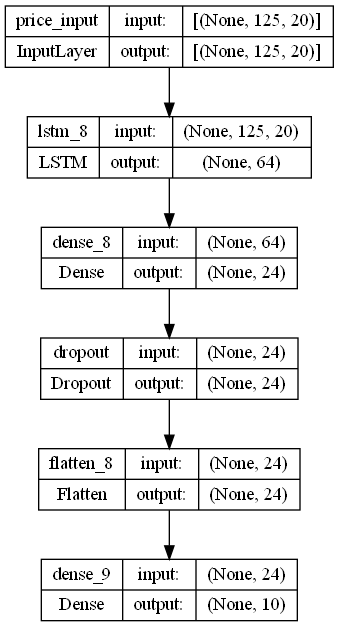

In [94]:
tf.keras.utils.plot_model(model.model, show_shapes=True)

##### 7 - Teste e calibração da rede LSTM ( Período de 01/01/2015 a 01/09/2021)

In [95]:
ticker = ['BPAC11.SA', 'CSMG3.SA', 'PGMN3.SA', 'ITUB4.SA', 'JBSS3.SA', 'MGLU3.SA','PETR4.SA', 'RDOR3.SA', 'VALE3.SA', 'EMBR3.SA']
history_range = {'start': datetime(2015, 1, 1), 
                 'end': datetime(2021, 9, 1)}

stock_eval = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')

In [96]:
stock_close_eval = stock_eval.iloc[:]['Adj Close'].reset_index(drop=True).fillna(fillna_const)

In [97]:
ds_eval = tf.data.Dataset.from_generator(dataGenerator, args=[stock_close_eval.values, 125, 22, 0, 1000], 
output_types=(tf.float32, tf.float32), output_shapes=((None, None), (None,)) )

In [98]:
model.evalModel(ds_eval, batch_size=5, steps=4)

tf.Tensor(174, shape=(), dtype=int32)
1/1 [==============================] - 0s 382ms/step
tf.Tensor(744, shape=(), dtype=int32)
1/1 [==============================] - 0s 442ms/step
tf.Tensor(996, shape=(), dtype=int32)
1/1 [==============================] - 0s 386ms/step
tf.Tensor(87, shape=(), dtype=int32)
1/1 [==============================] - 0s 386ms/step
tf.Tensor(843, shape=(), dtype=int32)
1/1 [==============================] - 0s 383ms/step
tf.Tensor(1281, shape=(), dtype=int32)
1/1 [==============================] - 0s 379ms/stepss: 0.0850 - accuracy: 0.40
tf.Tensor(1, shape=(), dtype=int32)
1/1 [==============================] - 1s 501ms/step
tf.Tensor(1224, shape=(), dtype=int32)
1/1 [==============================] - 0s 493ms/step
tf.Tensor(1486, shape=(), dtype=int32)
1/1 [==============================] - 0s 381ms/step
tf.Tensor(1080, shape=(), dtype=int32)
1/1 [==============================] - 0s 380ms/step
tf.Tensor(199, shape=(), dtype=int32)
1/1 [===================

In [99]:
m1_train_start = 100
m1_train_n = 125
m2_train_n = 22
_param = {}
_param ={'model_params':
    {'data_start_index':m1_train_start,
     'train_period':m1_train_n,
     'predict_period':m2_train_n}}

stock_data = stock_close.values[m1_train_start+m1_train_n:m1_train_start+m1_train_n+m2_train_n]

In [100]:
X, y, _k = getOneTrainElement(stock_close_eval.values, m1_train_start, m1_train_n, m2_train_n, 0)

1/1 [==============================] - 0s 462ms/step


In [101]:
alloc = model.get_allocations(stock_close_eval.values, **_param['model_params'])
print(alloc)
print_portfolio_values(alloc, stock_data)


1/1 [==============================] - 1s 578ms/step
[0.0000 0.0161 0.7101 0.0003 0.0401 0.0164 0.0001 0.2169 0.0000 0.0000]
Retorno do portfolio: R$0.0140
Desvio Padrão: 0.0028
Indice Sharpe: 0.2350


In [102]:
#true allocation for stock_data
print(y)
print_portfolio_values(y, stock_data)

[0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000]
Retorno do portfolio: R$0.8131
Desvio Padrão: 0.0993
Indice Sharpe: 0.3899


In [103]:
#calculate allocation based on current data using lstm risk model
current_stock_data = stock_close.values[m1_train_start:m1_train_start+m1_train_n]
risk_model = Model()
param={}
param ={'model_params':
    {'model_n':'LSTM',
    'epochs':1000}}
alloc = risk_model.get_allocations(current_stock_data, **param['model_params'])
print(alloc)
print_portfolio_values(alloc, current_stock_data)

1/1 [==============================] - 0s 409ms/step
[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000]
Retorno do portfolio: R$0.2277
Desvio Padrão: 0.0184
Indice Sharpe: 0.0998


In [104]:
# Utilização da mesma alocação para dados futuros
print_portfolio_values(alloc, stock_data)

Retorno do portfolio: R$-0.0317
Desvio Padrão: 0.0170
Indice Sharpe: -0.0889


##### 8 -  Simulação da Rede LSTM para o período de análise (01/09/2021 a 30/09/2022)

In [105]:
config_cerebro = {
    'assets':['BPAC11.SA', 'CSMG3.SA', 'PGMN3.SA', 'ITUB4.SA', 'JBSS3.SA', 'MGLU3.SA','PETR4.SA', 'RDOR3.SA', 'VALE3.SA', 'EMBR3.SA'],
    'benchmark':'^BVSP', # O Benchmark utilizado será o desempenho do Indice do Ibovespa
    'startd': datetime(2021, 9, 1),
    'endd'  : datetime(2022, 9, 30),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 100000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 5000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':TfModel(input_shapes,10, load_path="modelo_LSTM_salvo", model_nr=1),
    'model_params':
    {'data_start_index':0,
     'train_period':125,
     'model_n':'Trained_LSTM',
     'collectData':False,}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

In [106]:
d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])

Saldo inicial do Portfólio: 100000.00
1/1 [==============================] - 0s 58ms/step
Saldo final do  Portfólio: 111350.58


,CAGR,Max_Drawdown,Sharp_Ratio,Value
Trained_LSTM,10.514394,48.141111,0.125399,111350.581708


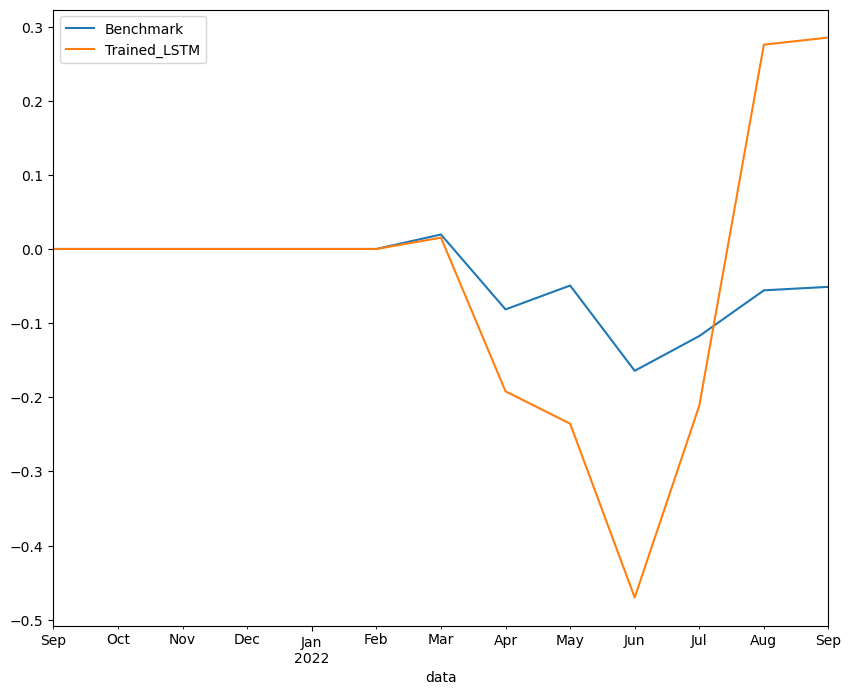

In [107]:
df = plotPortfolioReturns(d_res)

In [108]:
plotAllocation(ah.dropna())

In [109]:
getStatistic(d_stat).to_csv('Estatisticas_do_modelo_treinado_2021_2022.csv')
df.to_csv('drawdown_do_modelo_treinado_2021_2022.csv')

##### 9 - Backup da rede Neural final 

In [110]:
# model.saveModel('./modelo_LSTM_salvo')

##### Observação 1:
###### Para fins de compliance, é possível gravar o backup da rede neural final, lembrando que essa rede neural final
###### foi treinada a partir de um modelo pré-treinado anteriormente. Deve-se sempre estar atento se o novo modelo está generalizando bem os novos dados
###### e que não esteja ocorrendo o overfitting. 

##### Observação 2: 
###### Também é preciso ter em mente que o modelo aqui apresentado necessita do acréscimo de um módulo de detecção de anomalias, capaz de realizar
###### a parada do modelo em caso da detacção de um drawdown excessivo momentâneo e capaz de realizar o religamento do modelo após o fim da anomalia

##### Observação 3: 
###### Uma segunda possibilidade de melhoria do modelo seria o acréscimo de uma camada convolucional na entrada da rede neural, capaz de filtrar
###### variações bruscas na movimentação do preço dos ativos

##### Observação 4: 
###### Pode-se também, acrescentar dados adicionais de entrada da rede neural (tornando o modelo multivariado) como por exemplo dados exógenos como 
###### por exemplo preços de fechamento de indices como o SP500, os indices de bolsas européias e asiáticas, ou até mesmo dados endógenos, como por exemplo
###### indicadores como médias móveis, IFR, ATR, OBV, MACD, dentre outros.

##### Observação 5:
###### O modelo aqui apresentado utilizou como base uma carteira recomendada de setembro de 2021, por um período de 12 meses, deve-se avaliar a 
###### possibilidade de realizar a troca da carteira mensalmente, no intuito de se obter um alfa maior, potencializado os retornos

##### 10 - Modelo baseado no Github de Denis Vodchts: Episode_20_Battle_Of_Optimization_Methods link: https://github.com/CloseToAlgoTrading/CodeFromVideo/tree/master/Episode_20_Battle_Of_Optimization_Methods